<a href="https://colab.research.google.com/github/VanshDhimangithub/Predictive-Modelling-/blob/main/Water_predictive_modelling_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Challenge**

The challenge is to determine how various factors influence the water availability of each presented waterbody and ensuring water availability for each time interval of the year.

In this notebook, I will use one mathematical model, for prediction of Aquifer_Petrignano's Depth_to_Groundwater_P24. Similar approach can be reused for the prediction of groundwater depths of the other water bodies.


This famous quote aligns with the objective of this challenge.

# START



In [ ]:
pip install colorama

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore #Colorama is used for adding colored output to the terminal

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

np.random.seed(7) # reproducibility in random number generation.


In [ ]:
df = pd.read_csv("/content/sample_data/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Remove Rows with NaN Values in 'Rainfall_Bastia_Umbra' Column
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove Columns 'Depth_to_Groundwater_P24' and 'Temperature_Petrignano':
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [ ]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()


,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,1/1/2009,0.0,-31.14,5.2,-24530.688,2.4
1,2/1/2009,0.0,-31.11,2.3,-28785.888,2.5
2,3/1/2009,0.0,-31.07,4.4,-25766.208,2.4
3,4/1/2009,0.0,-31.05,0.8,-27919.296,2.4
4,5/1/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [ ]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


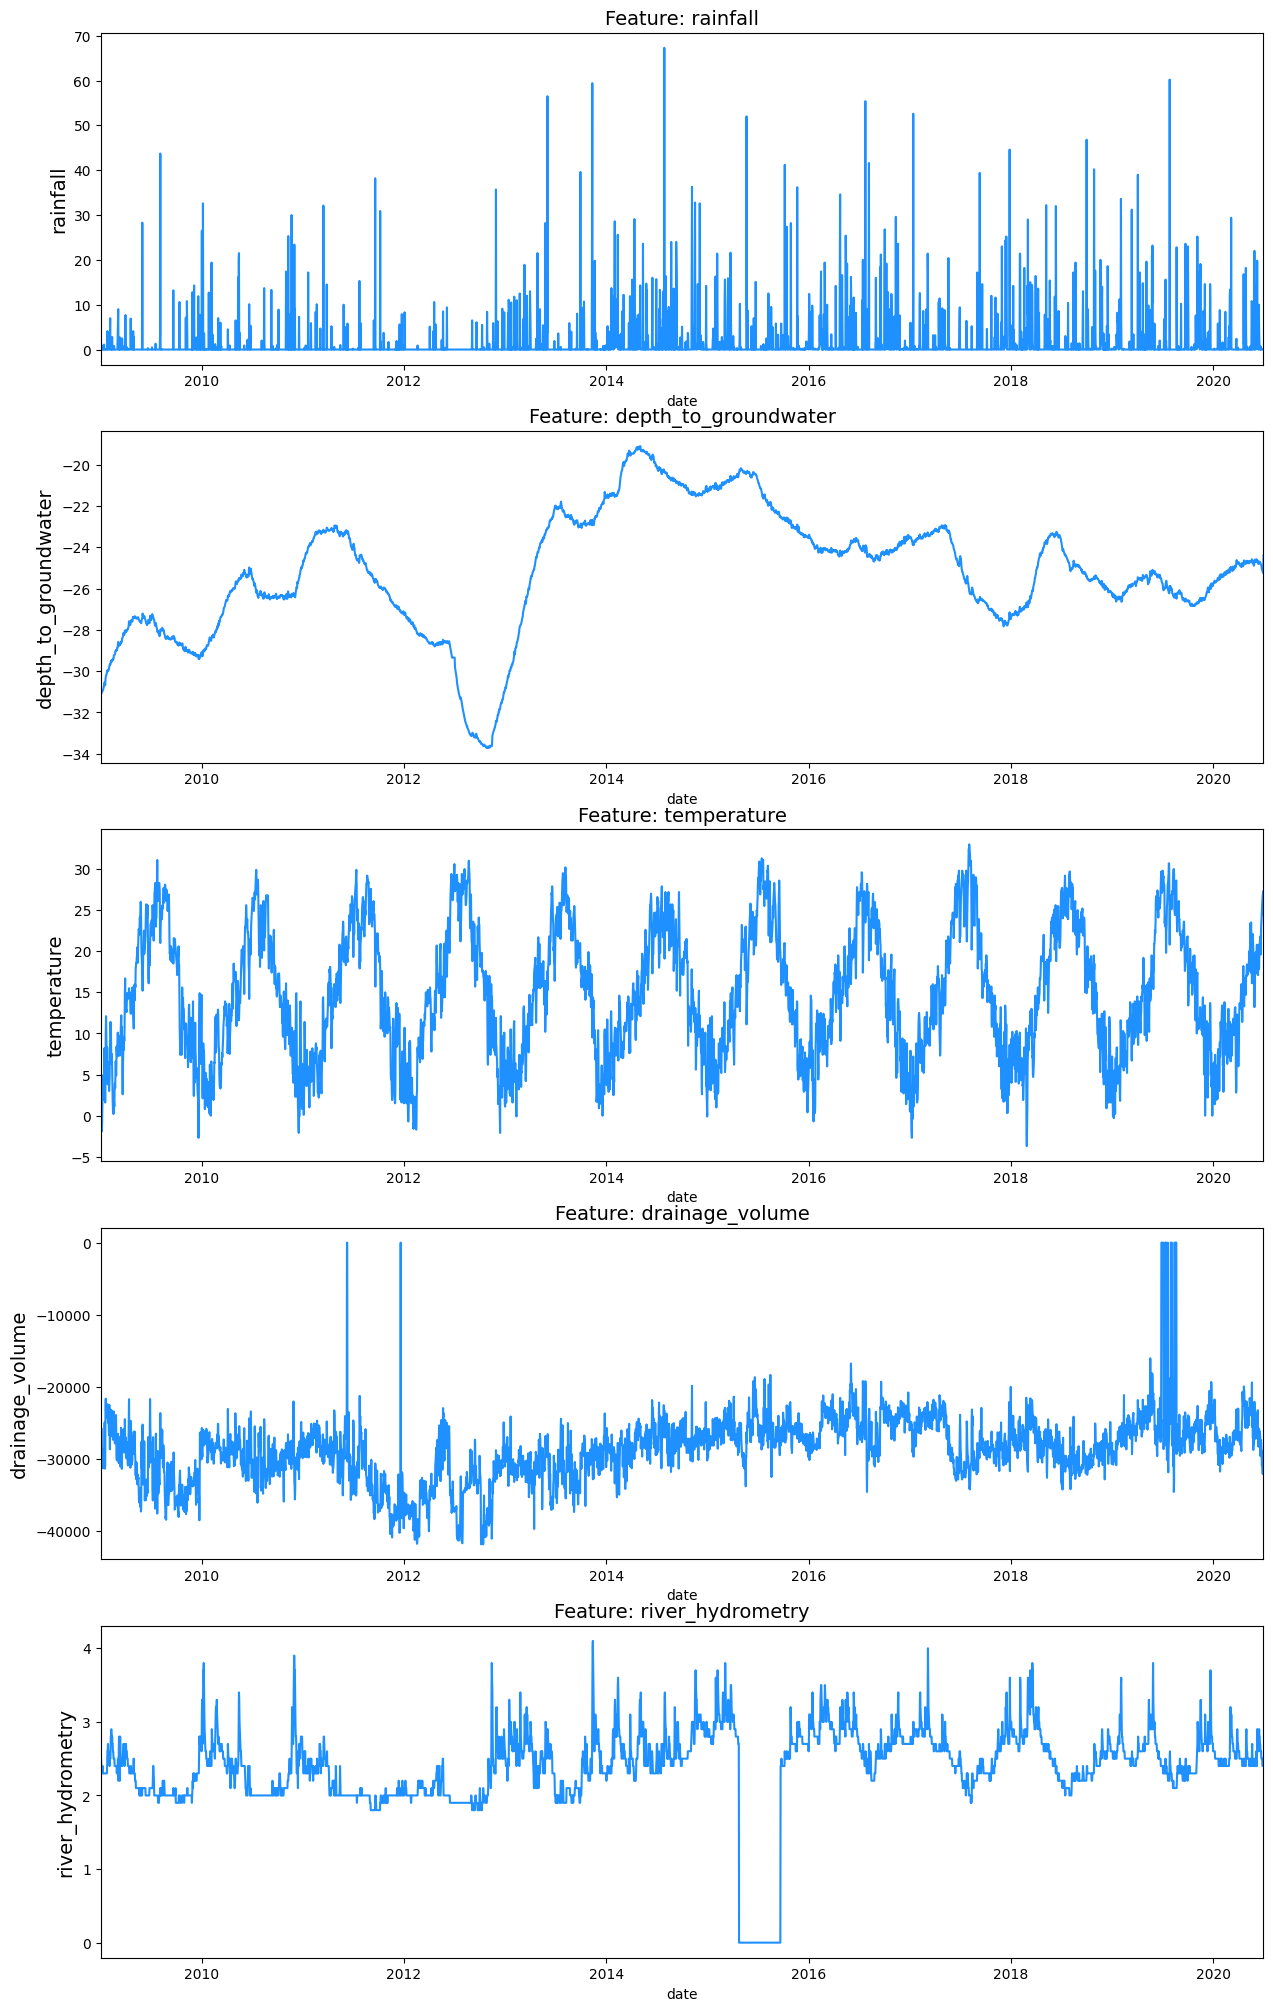

In [ ]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 2. Data Preprocessing ⚙️

Data preprocessing

In [ ]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [ ]:
df['delta'].sum(), df['delta'].count()
#calculates the sum of the time intervals ('delta' column) and the count of non-null values in the 'delta' column of the DataFrame df. Here's the meaning of each part:

(Timedelta('5480 days 00:00:00'), 5480)

handle missing values

In [ ]:
df = df.drop('delta', axis=1)
df.isna().sum()


,0
date,0
rainfall,0
depth_to_groundwater,34
temperature,0
drainage_volume,1
river_hydrometry,0


(14245.0, 18443.0)

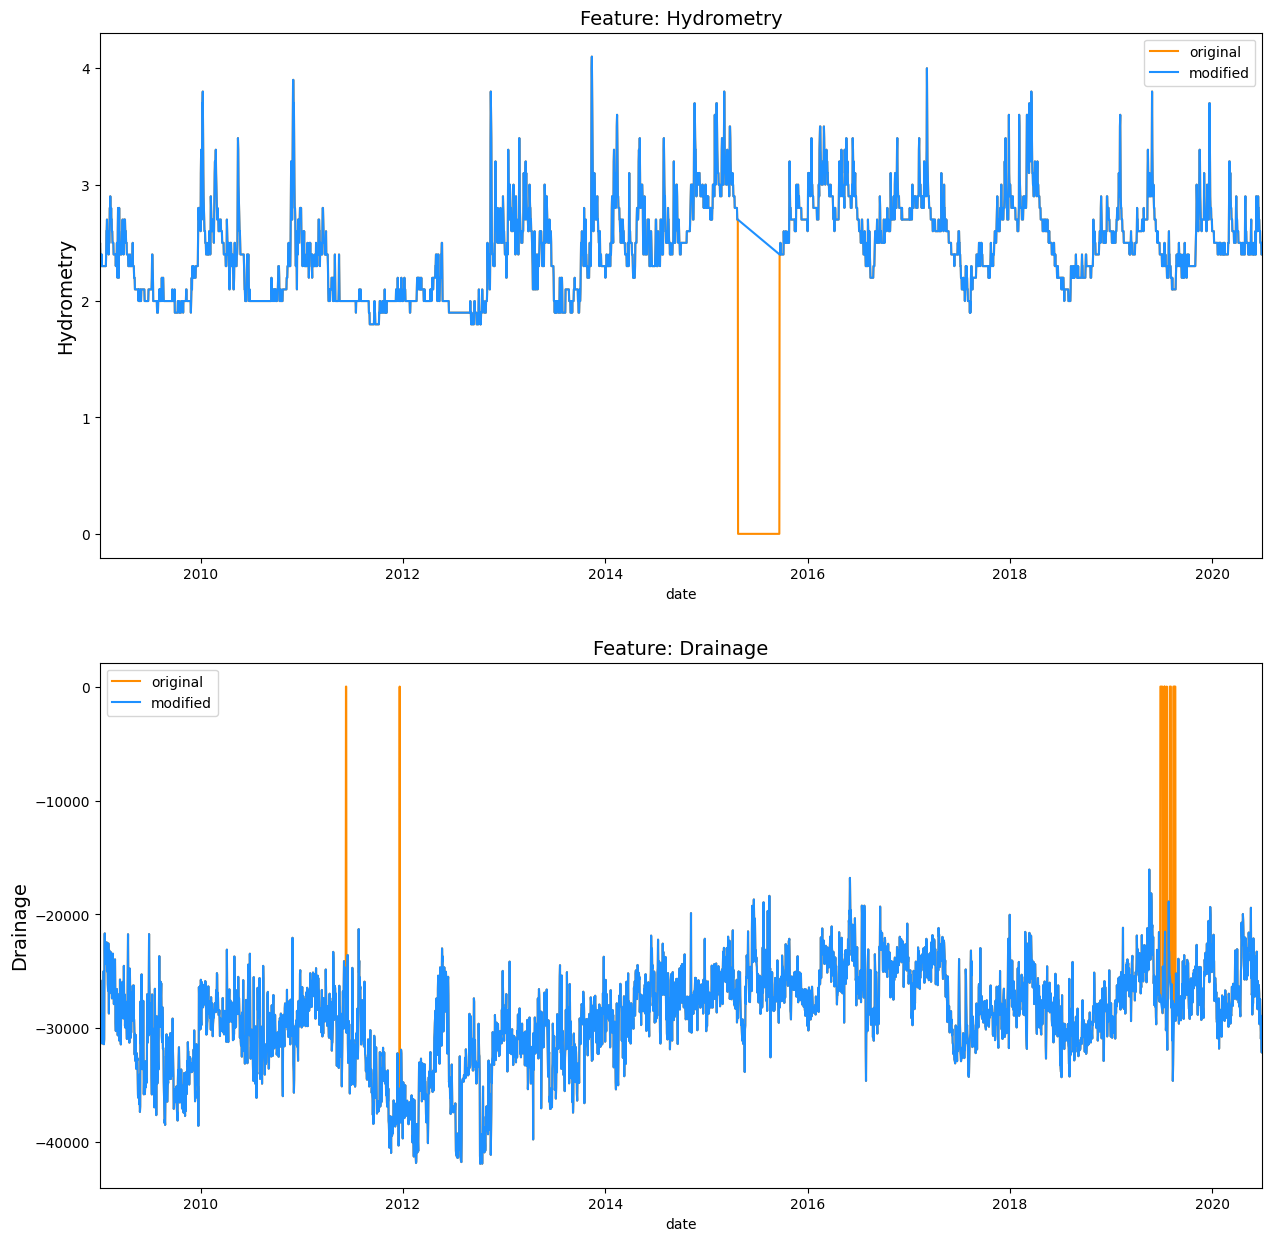

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

In [ ]:
# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

# sns.heatmap(df.T.isna(), cmap='Blues')
# ax.set_title('Missing Values', fontsize=16)

# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# plt.show()

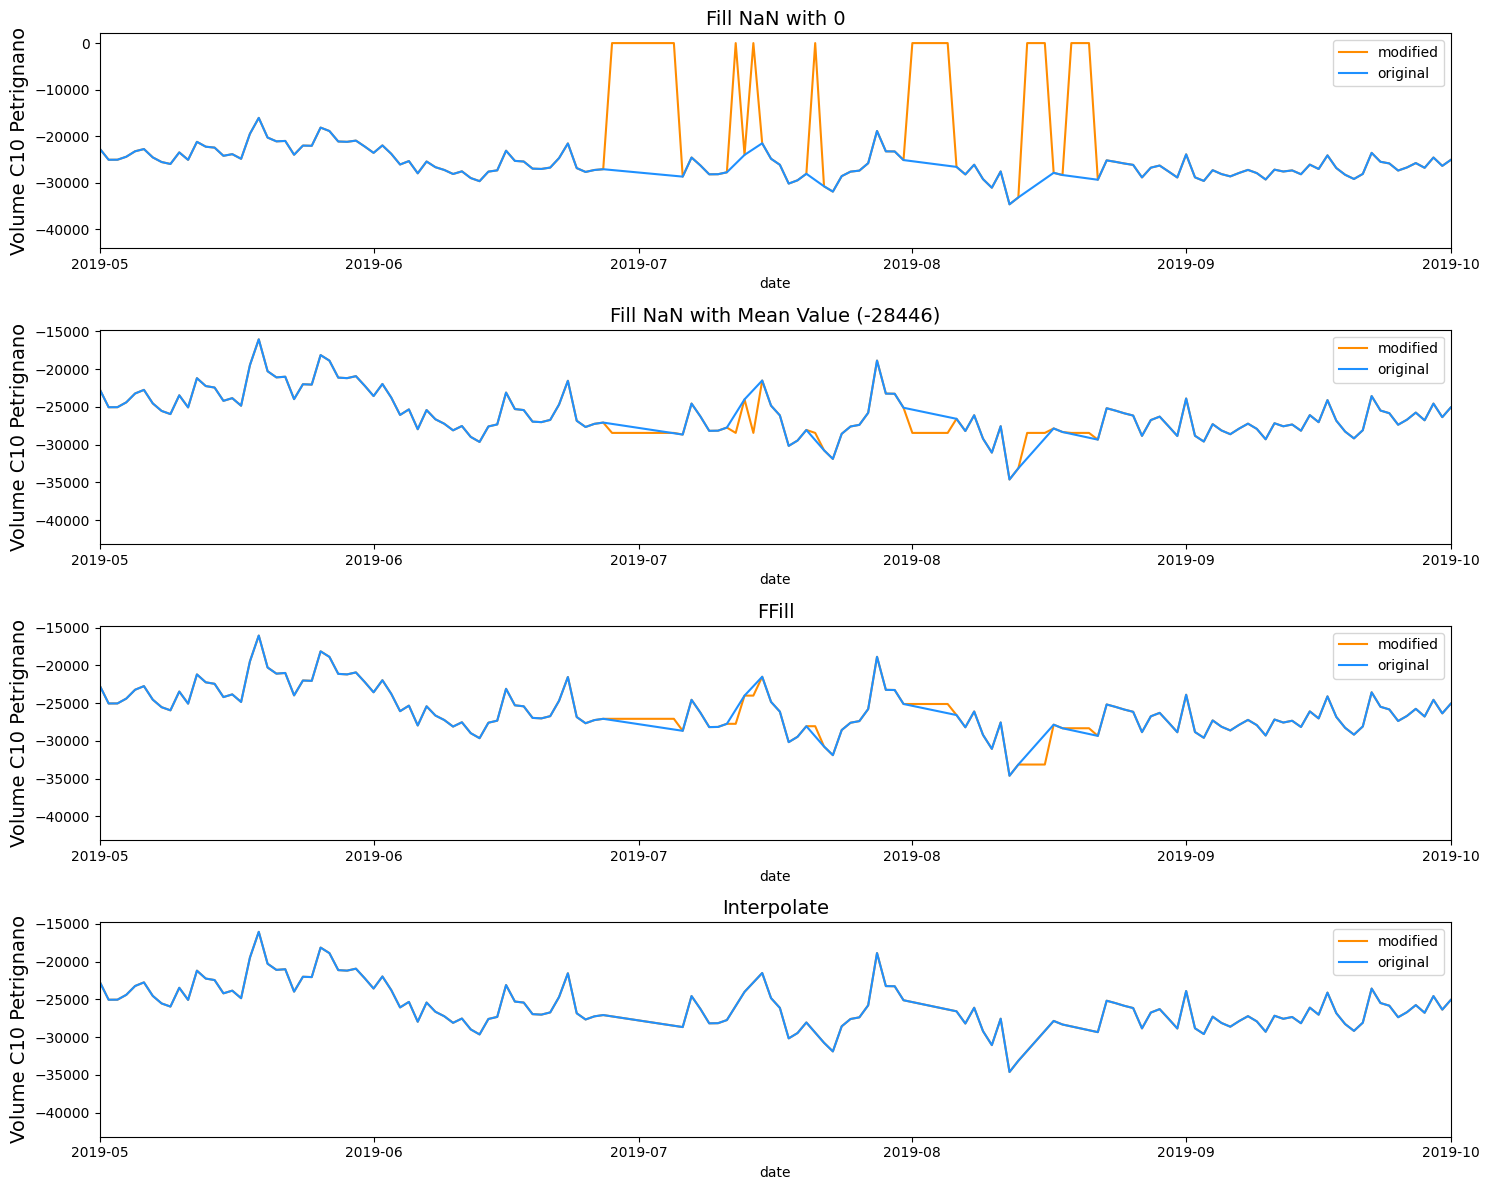

In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

In [ ]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date


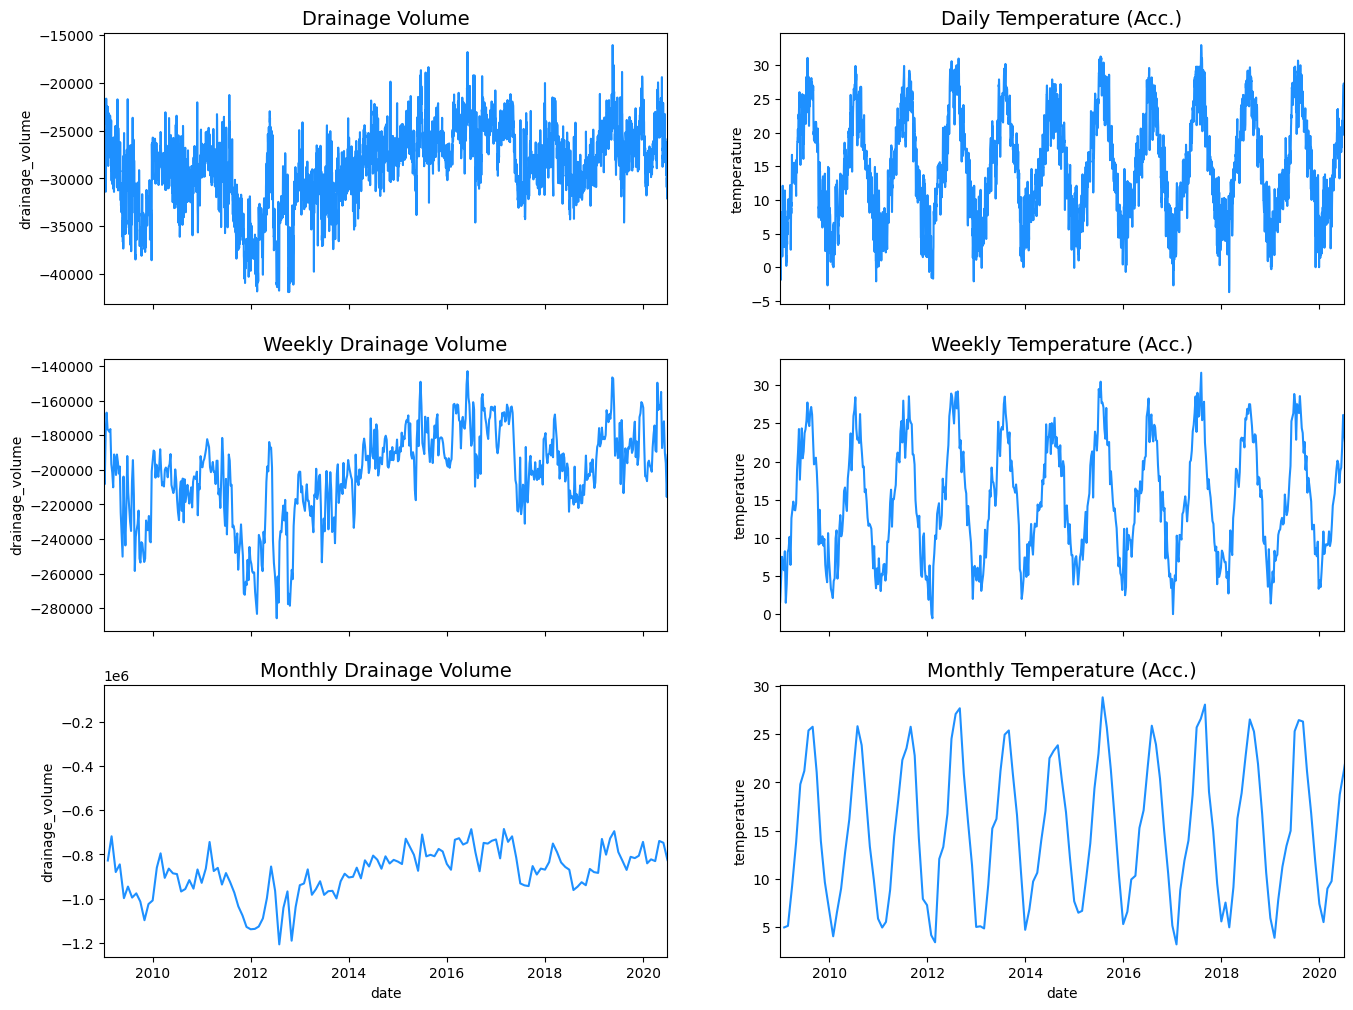

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])

ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])

ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df_temp_weekly = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_temp_weekly['date'], y=resampled_df_temp_weekly['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df_temp_monthly = df[['date', 'temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_temp_monthly['date'], y=resampled_df_temp_monthly['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()


In [ ]:
# As we can see, downsample to weekly could smooth the data and hgelp with analysis
downsample = df[['date',
                 'depth_to_groundwater',
                 'temperature',
                 'drainage_volume',
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

2.3 Stationarity

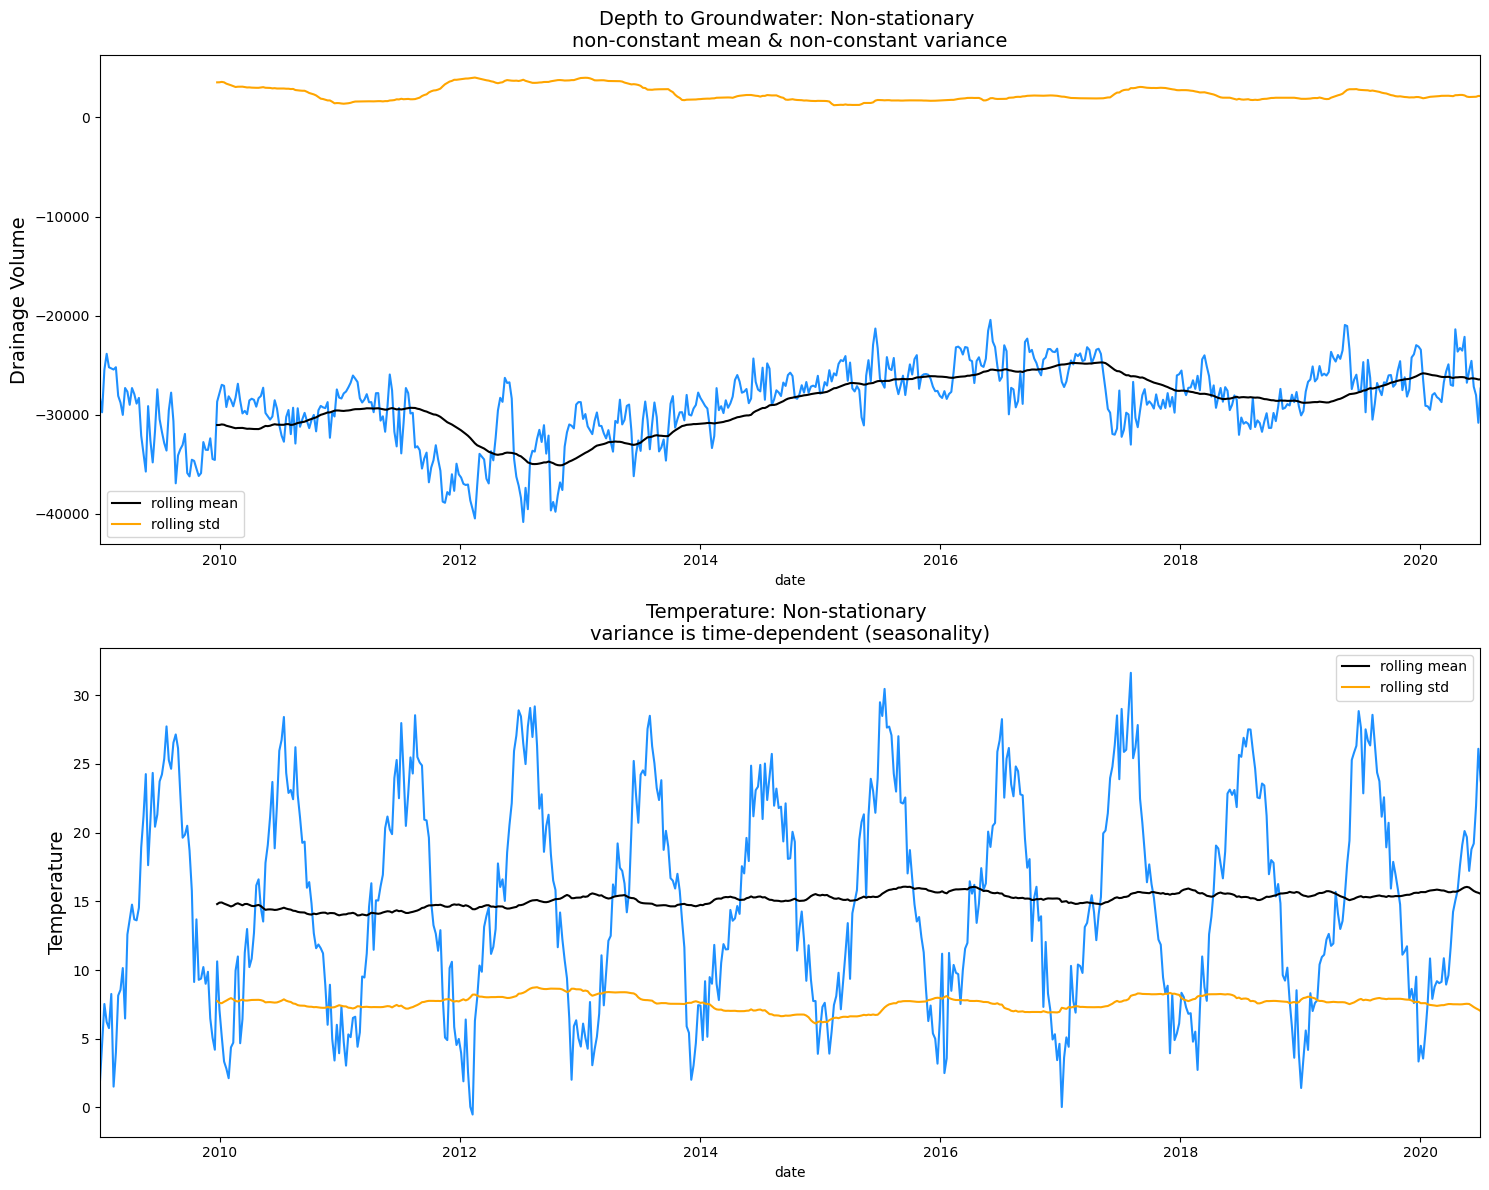

In [ ]:
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-3.6761822016854384,
 0.004460922860444057,
 6,
 776,
 {'1%': -3.438804978547988,
  '5%': -2.8652717302548396,
  '10%': -2.5687571389759802},
 -915.0706717422506)

Now, we are going to check for each variable:

The p-value is less than 0.05
Check the range of the ADF statistic compared with critical_values

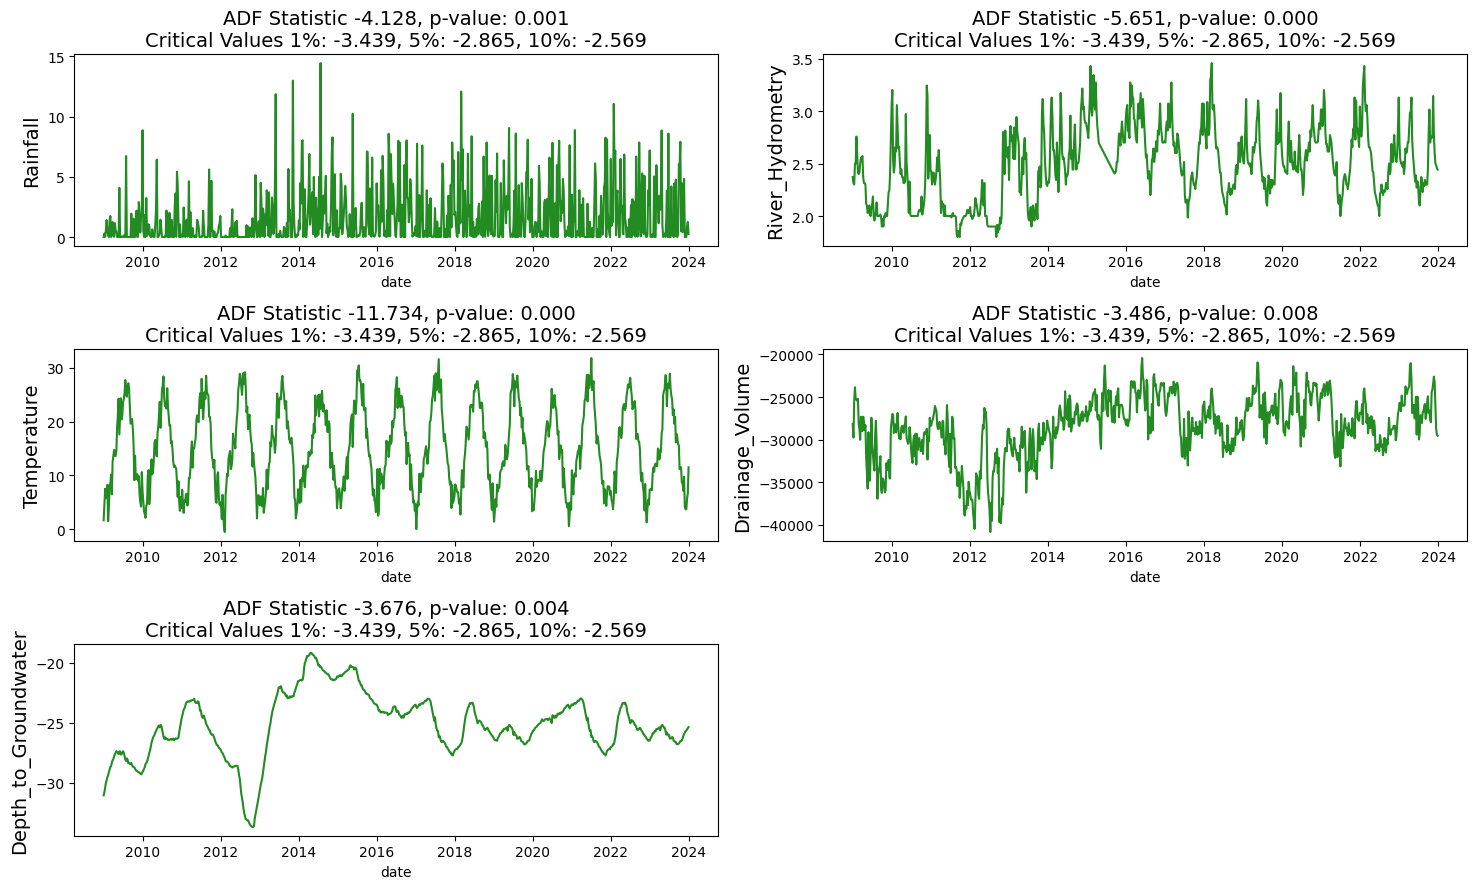

In [ ]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

2.3.2 Transforming

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

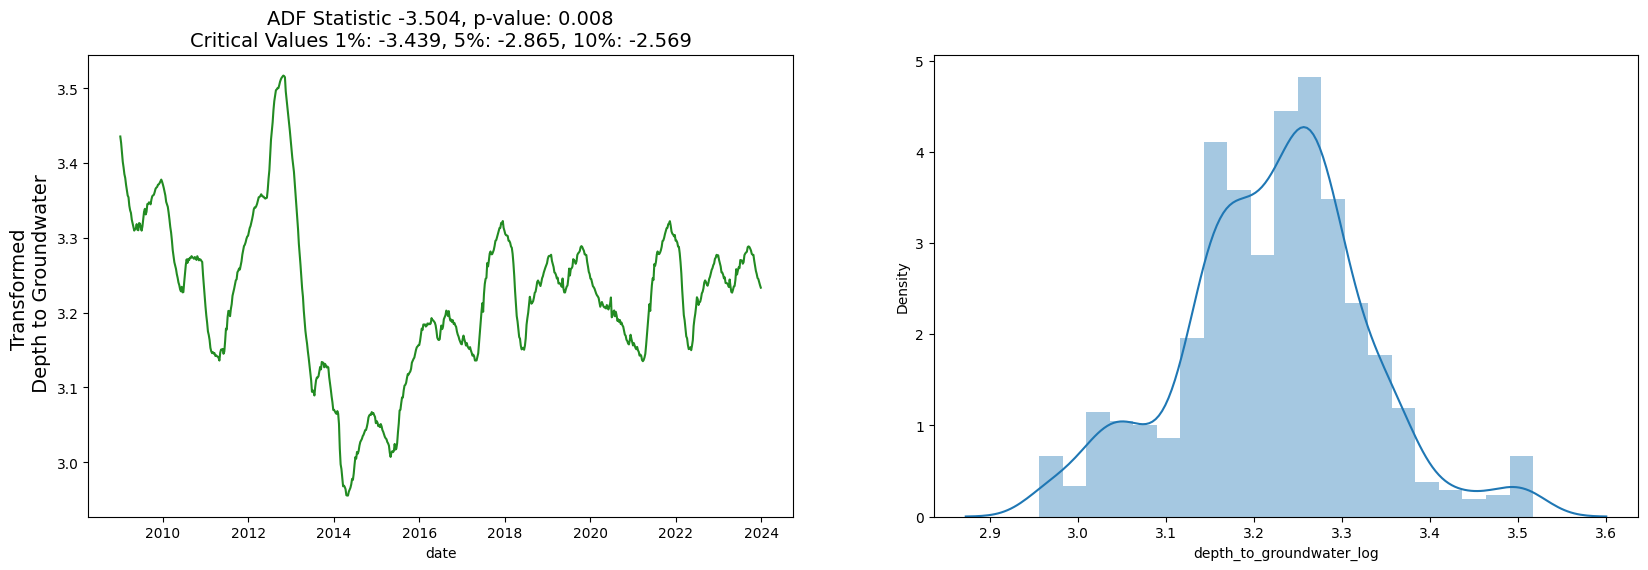

In [ ]:



# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

2.3.3 Differencing

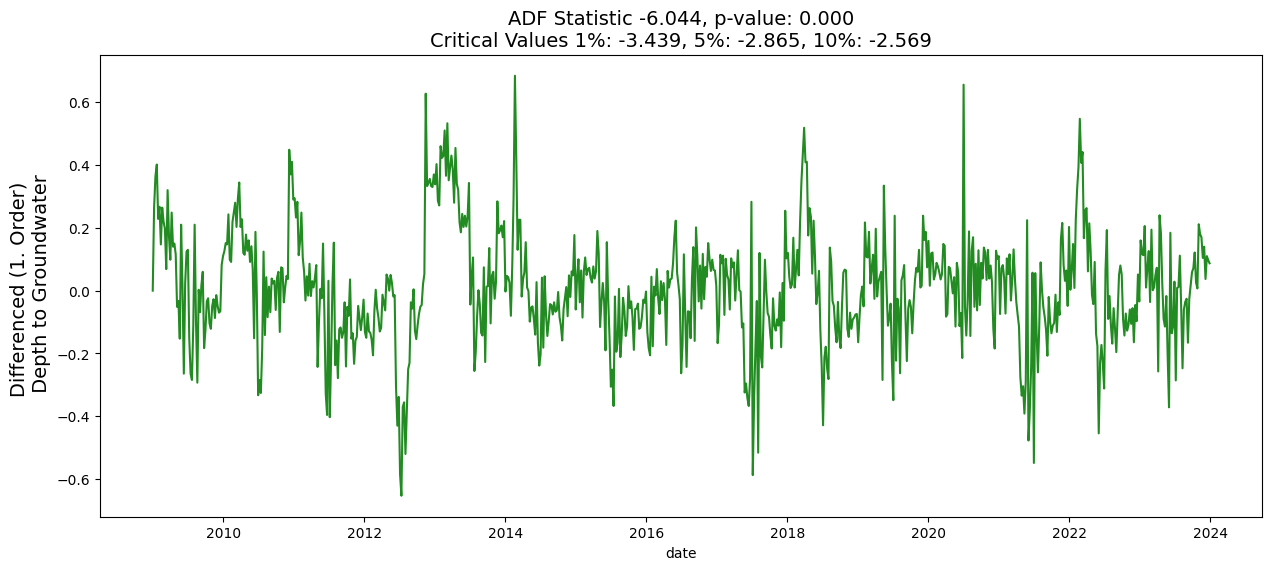

In [ ]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

# 3. Feature engineering 🔧

In [ ]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).isocalendar().week
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
1970-01-01 00:00:00.000000000,2009-01-01,2009,1,1,1,<NA>,1,1
1970-01-01 00:00:00.000000001,2009-01-08,2009,1,8,8,<NA>,1,1
1970-01-01 00:00:00.000000002,2009-01-15,2009,1,15,15,<NA>,1,1
1970-01-01 00:00:00.000000003,2009-01-22,2009,1,22,22,<NA>,1,1
1970-01-01 00:00:00.000000004,2009-01-29,2009,1,29,29,<NA>,1,1


3.1 Encoding Cyclical Features

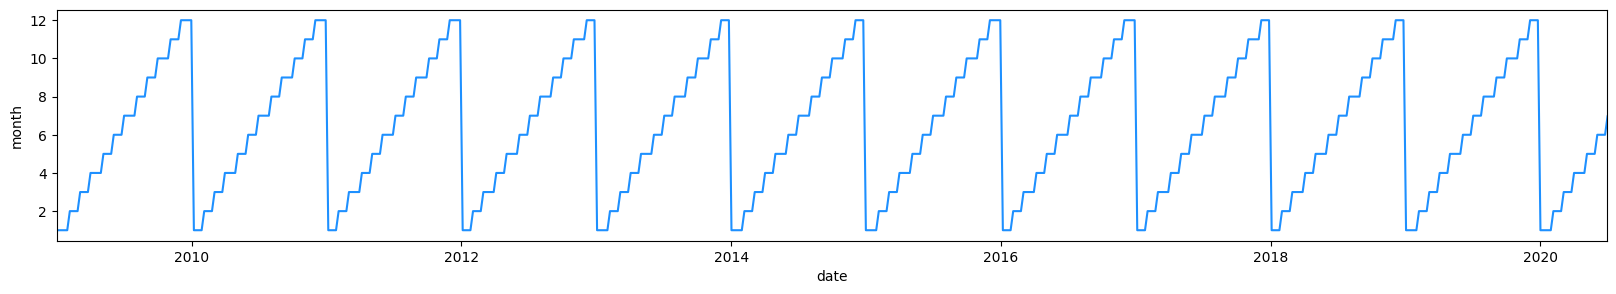

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()


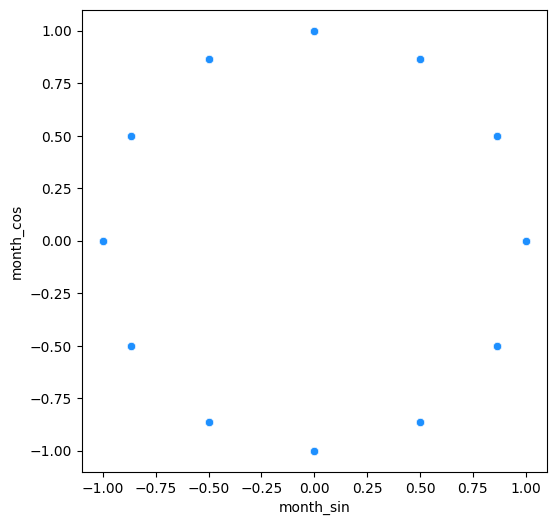

In [ ]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

3.2 TimeSeries Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

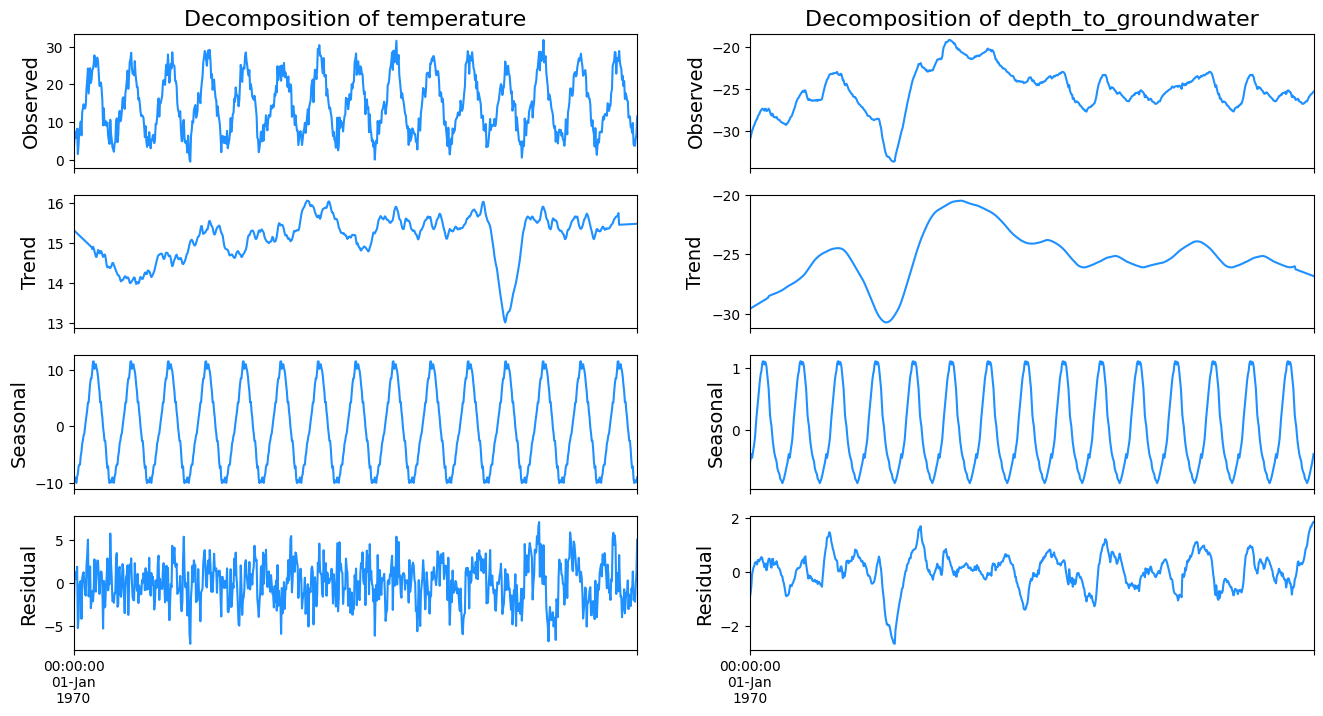

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your DataFrame has a datetime index
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0, i], legend=False, color='dodgerblue')
    ax[0, i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3, i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Residual', fontsize=14)

plt.show()


In [ ]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

# 4. Exploratory Data Analysis 📊

Now, we are going to plot the data and try to extract some knowledge.

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

As we can see:

depth_to_groundwater: reaches its maximum around May/June and its minimum around November
temperature: reaches its maxmium around August and its minimum around January
drainage_volume: reaches its minimum around July.
river_hydrometry: reaches its maximum around February/March and its minimum around September

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m',
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

4.**1 Autocorrelation Analysis**

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

# Modelling

In [ ]:



from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)
#it ensures that each fold is a superset of all previous folds, providing a more reliable estimate of the model's performance on unseen data


# Time series cross-validation splits

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.
model performs on different time periods and how it adapts to changing patterns in the data.

# 5.1 Models for Univariate Time Series



First of all, we are going to analize univariate TimeSeries forecasting.

Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the streamflow. Therefore, each second, you will only have a one-dimensional value, which is respresenting the streamflow.

In [ ]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

# Arima

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data. The model assumes that the time-series is stationary. It consists of three main parts:

In [ ]:
pip install Statsmodels

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_valid is a DataFrame with datetime index
# Assuming y_valid is a DataFrame or Series with datetime index

# Generate some example data
x_valid = pd.DataFrame(index=pd.date_range(start='2023-01-01', periods=510, freq='D'))
y_valid = pd.Series(np.random.randn(510), index=x_valid.index)

# Your plotting code
plt.plot(x_valid.index, y_valid, label='Ground truth')
plt.show()


In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error, precision_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train and y_valid are your training and validation datasets

# Fit the auto_arima model
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# Generate predictions (forecasting n_periods ahead)
y_pred = model.predict(n_periods=len(y_valid))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

# Optionally, convert continuous predictions to binary for precision/accuracy (if needed)
# Note: You might want to adjust this threshold based on your specific use case
y_pred_binary = (y_pred > 0).astype(int)
y_valid_binary = (y_valid > 0).astype(int)

# Calculate Precision and Accuracy (assuming binary classification)
precision = precision_score(y_valid_binary, y_pred_binary)
accuracy = accuracy_score(y_valid_binary, y_pred_binary)

# Print the metrics
print(f"RMSE: {rmse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot the diagnostics
model.plot_diagnostics(figsize=(16,8))
plt.show()


# LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

In [ ]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from colorama import Fore

# Assuming you have the dataset (univariate_df) already loaded
data = univariate_df.filter(['y'])  # Your column of interest, 'y'
dataset = data.values

# MinMax scaling
scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

# Parameters
look_back = 52
train_size = int(len(scaled_data) * 0.8)  # Adjust based on your dataset

# Split data into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

# Create dataset function
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Create the datasets
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

# Let's predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invert predictions (to get them back to the original scale)
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get RMSE and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])

print(Fore.GREEN + f'RMSE: {score_rmse:.4f}')
print(Fore.GREEN + f'MAE: {score_mae:.4f}')

# To calculate Precision and Accuracy, we first need to classify the predictions
# Threshold to classify the predicted values as above or below 0
threshold = 0
train_predict_binary = (train_predict > threshold).astype(int)
test_predict_binary = (test_predict > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Calculate Precision and Accuracy (for binary classification)
precision = precision_score(y_test_binary[0], test_predict_binary[:,0])
accuracy = accuracy_score(y_test_binary[0], test_predict_binary[:,0])

# Print Precision and Accuracy
print(Fore.GREEN + f'Precision: {precision:.4f}')
print(Fore.GREEN + f'Accuracy: {accuracy:.4f}')


In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to plot the forecast
def plot_forecast(x_train_ticks, y_train, x_test_ticks, test_predict, y_test, score_mae, score_rmse, title_suffix):
    f, ax = plt.subplots(1)
    f.set_figheight(6)
    f.set_figwidth(15)

    sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set', color='navajowhite')
    sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction')
    sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground Truth')

    ax.set_title(f'Prediction {title_suffix} \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Depth to Groundwater', fontsize=14)

    plt.show()

# Example usage with different datasets or prediction results
# Assuming you have multiple sets of data and metrics
plot_forecast(x_train_ticks, y_train, x_test_ticks, test_predict, y_test, score_mae, score_rmse, "(Dataset 1)")
plot_forecast(x_train_ticks, y_train, x_test_ticks, test_predict_2, y_test_2, score_mae_2, score_rmse_2, "(Dataset 2)")
plot_forecast(x_train_ticks, y_train, x_test_ticks, test_predict_3, y_test_3, score_mae_3, score_rmse_3, "(Dataset 3)")

# Repeat for as many datasets or results you have

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the function to plot the forecast with additional elements
def plot_forecast_with_residuals(x_train_ticks, y_train, x_test_ticks, test_predict, y_test, score_mae, score_rmse, title_suffix):
    f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
    f.set_figheight(10)
    f.set_figwidth(15)

    # Plot the forecast
    sns.lineplot(x=x_train_ticks, y=y_train, ax=ax1, label='Train Set', color='navajowhite')
    sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax1, color='green', label='Prediction')
    sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax1, color='orange', label='Ground Truth')

    # Calculate residuals
    residuals = y_test[0] - test_predict[:,0]

    # Plot residuals as a histogram
    sns.histplot(residuals, kde=True, ax=ax2, color='blue', bins=20)
    ax2.set_title('Residuals Distribution')
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Frequency')

    # Add a shaded area for the confidence interval
    ci = 1.96 * np.std(residuals) / np.sqrt(len(residuals))
    ax1.fill_between(x_test_ticks, (test_predict[:,0] - ci), (test_predict[:,0] + ci), color='green', alpha=.2, label='95% Confidence Interval')

    ax1.set_title(f'Prediction {title_suffix} \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Depth to Groundwater', fontsize=14)
    ax1.legend()

    plt.tight_layout()
    plt.show()
    plot_forecast_with_residuals(x_train_ticks, y_train, x_test_ticks, test_predict, y_test, score_mae, score_rmse, "(Dataset 1)")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Example data (replace with your actual data)
x_train_ticks = pd.date_range(start='2020-01-01', periods=100, freq='D')
y_train = np.random.rand(100) * 100
x_test_ticks = pd.date_range(start='2020-04-10', periods=20, freq='D')
test_predict = np.random.rand(20, 1) * 100
y_test = np.random.rand(20) * 100
score_mae = 5.0
score_rmse = 10.0

# Function to plot the forecast with additional elements
def plot_comprehensive_forecast(x_train_ticks, y_train, x_test_ticks, test_predict, y_test, score_mae, score_rmse, title_suffix):
    f, axs = plt.subplots(5, 1, figsize=(15, 25), gridspec_kw={'height_ratios': [3, 1, 1, 2, 2]})

    # Time Series Plot with Predictions and Confidence Intervals
    sns.lineplot(x=x_train_ticks, y=y_train, ax=axs[0], label='Train Set', color='navajowhite')
    sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=axs[0], color='green', label='Prediction')
    sns.lineplot(x=x_test_ticks, y=y_test, ax=axs[0], color='orange', label='Ground Truth')

    # Calculate residuals
    residuals = y_test - test_predict[:,0]
    ci = 1.96 * np.std(residuals) / np.sqrt(len(residuals))
    axs[0].fill_between(x_test_ticks, (test_predict[:,0] - ci), (test_predict[:,0] + ci), color='green', alpha=.2, label='95% Confidence Interval')

    axs[0].set_title(f'Prediction {title_suffix} \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
    axs[0].set_xlabel('Date', fontsize=14)
    axs[0].set_ylabel('Depth to Groundwater', fontsize=14)
    axs[0].legend()

    # Residuals Distribution
    sns.histplot(residuals, kde=True, ax=axs[1], color='blue', bins=20)
    axs[1].set_title('Residuals Distribution')
    axs[1].set_xlabel('Residuals')
    axs[1].set_ylabel('Frequency')

    # Residuals Over Time
    sns.lineplot(x=x_test_ticks, y=residuals, ax=axs[2], color='red')
    axs[2].set_title('Residuals Over Time')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Residuals')

    # Prediction vs. Actual Scatter Plot
    sns.scatterplot(x=y_test, y=test_predict[:,0], ax=axs[3], color='purple')
    axs[3].set_title('Prediction vs. Actual')
    axs[3].set_xlabel('Actual Values')
    axs[3].set_ylabel('Predicted Values')
    axs[3].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

    # Error Metrics Bar Chart
    metrics = ['MAE', 'RMSE']
    scores = [score_mae, score_rmse]
    sns.barplot(x=metrics, y=scores, ax=axs[4], palette='viridis')
    axs[4].set_title('Error Metrics')
    axs[4].set_ylabel('Score')

    plt.tight_layout()
    plt.show()

# Example usage with a dataset
plot_comprehensive_forecast(x_train_ticks, y_train, x_test_ticks, test_predict, y_test, score_mae, score_rmse, "(Dataset 1)")

# Repeat for other datasets or results
# plot_comprehensive_forecast(x_train_ticks, y_train, x_test_ticks, test_predict_2, y_test_2, score_mae_2, score_rmse_2, "(Dataset 2)")
# plot_comprehensive_forecast(x_train_ticks, y_train, x_test_ticks, test_predict_3, y_test_3, score_mae_3, score_rmse_3, "(Dataset 3)")

CONCLUSION:
# The best results are taken from Univariate LSTM (with rolling window of 1 year)